# Convolutional Variational Autoencoder

## Setup

In [40]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import os
import math
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
from tqdm import trange
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

## Load the dataset

In [2]:
def draw_line(angle, height, width, w=2.):
    m = np.zeros((height, width, 1))
    x0 = height*0.5
    y0 = width*0.5
    x1 = x0 + (x0 - 1) * math.cos(-angle)
    y1 = y0 + (y0 - 1) * math.sin(-angle)
    flip = False
    if abs(y0 - y1) < abs(x0 - x1):
        x0, x1, y0, y1 = y0, y1, x0, x1
        flip = True
    if y1 < y0:
        x0, x1, y0, y1 = x1, x0, y1, y0
    x0, x1 = x0 - w / 2, x1 - w / 2
    dx = x1 - x0
    dy = y1 - y0
    ds = dx / dy if dy != 0 else 0
    yi = int(math.ceil(y0)), int(y1)
    points = []
    for y in range(int(y0), int(math.ceil(y1))):
        if y < yi[0]:
            weight = yi[0] - y0
        elif y > yi[1]:
            weight = y1 - yi[1]
        else:
            weight = 1
        xs = x0 + (y - y0 - .5) * ds
        xe = xs + w
        xi = int(math.ceil(xs)), int(xe)
        if xi[0] != xi[1]:
            points.append((y, slice(xi[0], xi[1]), weight))
        if xi[0] != xs:
            points.append((y, int(xs), weight * (xi[0] - xs)))
        if xi[1] != xe:
            points.append((y, xi[1], weight * (xe - xi[1])))
    if flip:
        points = [(x, y, z) for y, x, z in points]
    for y, x, z in points:
        m[y, x] += 2 * z
    m -= 1
    m = (m+1)/2
    m = m.clip(0, 1)
    return m
dataset = np.empty((1000,28,28,1), dtype='float32')
for i in range(1000):
    angle = 2 * math.pi * np.random.random()
    dataset[i,:,:,:] = draw_line(angle, 28, 28)
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(32)   
test_dataset = tf.data.Dataset.from_tensor_slices(dataset[0:100,:,:,:]).batch(32)   

2022-07-09 22:40:47.599140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-09 22:40:48.273814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13606 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:89:00.0, compute capability: 8.6


## Define the encoder and decoder networks


In [3]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim),
            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        #mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        #return mean, logvar
        return self.encoder(x)

    def reparameterize(self, mean, logvar=-1.00):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [4]:
latent_dim = 2
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)
#model.load_weights('./checkpoint/cvae')

In [5]:
optimizer = tf.keras.optimizers.Adam(1e-4)
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean)**2*tf.exp(-logvar)+logvar+log2pi), axis=1)
def log_prior_z_pdf(z):
    r = tf.norm(z, axis=1)
    a = 100.0
    b = 100.0
    return (a-1)*tf.math.log(r)-b*r-a*tf.math.log(b)-tf.math.lgamma(a)
def compute_loss(model, x):
    mean = model.encode(x)
    logvar = -10.0
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_prior_z_pdf(z)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [6]:
def generate_and_save_images(model, epoch, test_sample):
    mean = model.encode(test_sample)
    logvar = -10.0
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle('Epoch %d'%epoch)
    plt.savefig('plots/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

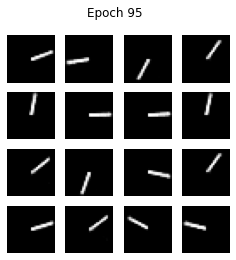

Epoch: 95, Test set ELBO: -941.885009765625, time elapse for current epoch: 0.18065762519836426


In [8]:
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
for epoch in range(100):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()
    if epoch%5==0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        generate_and_save_images(model, epoch, test_sample)        
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
            .format(epoch, elbo, end_time - start_time))

In [ ]:
#model.save_weights('./checkpoint/cvae')

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [12]:
def plot_latent_images(model, n, digit_size=28):
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    
    R = 2.0
    grid_x = np.linspace(-R, R, n)
    grid_y = np.linspace(-R, R, n)
    
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

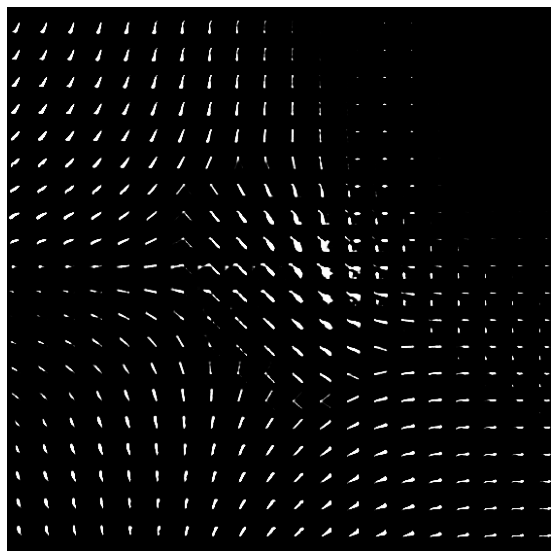

In [13]:
plot_latent_images(model, 20)

In [66]:
def plot_latent_distribution(model):
    X = np.empty((1000,28,28,1))
    A = np.empty((1000,1))
    for i in range(X.shape[0]):
        angle = 2 * math.pi * np.random.random()
        X[i,:,:,:] = draw_line(angle, 28, 28)
        A[i,0] = angle
    Z = model.encoder(X)
    df = pd.DataFrame(np.concatenate([Z,A], axis=1))
    fig = px.density_heatmap(df, x=0, y=1, nbinsx=200, nbinsy=200,
                             color_continuous_scale="Viridis")
    fig = px.scatter(df, x=0, y=1, color=2)
    fig.show()
    return df

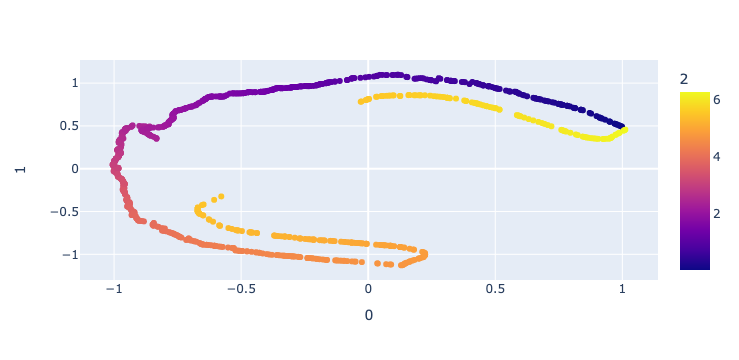

,0,1,2
0,-0.456114,-0.746166,5.266716
1,0.070280,-0.895773,4.954787
2,-0.151590,1.009935,1.078543
3,-0.967798,0.401125,2.512945
4,-0.844102,-0.666215,3.972344
...,...,...,...
995,-0.520632,-0.716759,5.302612
996,-0.303794,-1.022572,4.488626
997,-0.914958,-0.551633,3.848111
998,0.141471,-1.113138,4.723052


In [67]:
plot_latent_distribution(model)

100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.73it/s]


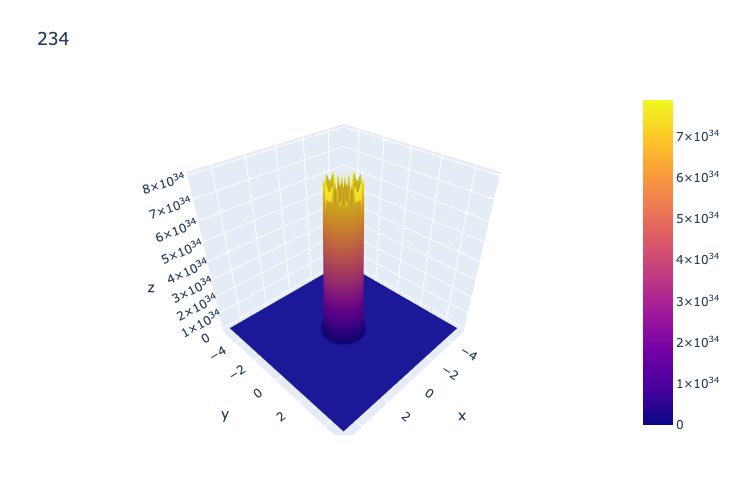

In [18]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from tqdm import trange
L = 100
R = 5
x, y = np.linspace(-R, R, L), np.linspace(-R, R, L)
z = np.empty((L,L))
for i in trange(L):
    for j in range(L):
        z[i,j] = np.exp(1000+log_prior_z_pdf(tf.constant([[x[i], y[j]]], dtype=tf.float32)))
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='234', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()